In [1]:
import pandas as pd
import numpy as np
import gc
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import os
import joblib
import random
import math
from tqdm.auto import tqdm 

from scipy.interpolate import interp1d

from math import pi, sqrt, exp
import sklearn,sklearn.model_selection
import torch
from torch import nn,Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")

from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import ctypes

def normalize(y):
    mean = y[:,0].mean().item()
    std = y[:,0].std().item()
    y[:,0] = (y[:,0]-mean)/(std+1e-16)
    mean = y[:,1].mean().item()
    std = y[:,1].std().item()
    y[:,1] = (y[:,1]-mean)/(std+1e-16)
    return y

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
EPOCHS = 7
WARMUP_PROP = 0.2
BS = 1
WORKERS = 4
TRAIN_PROP = 0.9
max_chunk_size = 24*60*100

In [3]:
def plot_history(history, model_path=".", show=True):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["valid_loss"], label="Validation Loss")
    plt.title("Loss evolution")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(model_path, "loss_evo.png"))
    if show:
        plt.show()
    plt.close()

    plt.figure()
    plt.plot(epochs, history["lr"])
    plt.title("Learning Rate evolution")
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.savefig(os.path.join(model_path, "lr_evo.png"))
    if show:
        plt.show()
    plt.close()

In [4]:
class ResidualBiGRU(nn.Module):
    def __init__(self, hidden_size, n_layers=1, bidir=True):
        super(ResidualBiGRU, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            n_layers,
            batch_first=True,
            bidirectional=bidir,
        )
        
        dir_factor = 2 if bidir else 1
        self.fc1 = nn.Linear(hidden_size * dir_factor, hidden_size * dir_factor * 2)
        self.ln1 = nn.LayerNorm(hidden_size * dir_factor * 2)
        self.fc2 = nn.Linear(hidden_size * dir_factor * 2, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

    def forward(self, x, h=None):
        res, new_h = self.gru(x, h)
        # res.shape = (batch_size, sequence_size, 2*hidden_size)

        res = self.fc1(res)
        res = self.ln1(res)
        res = nn.functional.relu(res)

        res = self.fc2(res)
        res = self.ln2(res)
        res = nn.functional.relu(res)

        # skip connection
        res = res + x

        return res, new_h

class MultiResidualBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, n_layers, bidir=True):
        super(MultiResidualBiGRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.n_layers = n_layers

        self.fc_in = nn.Linear(input_size, hidden_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.res_bigrus = nn.ModuleList(
            [
                ResidualBiGRU(hidden_size, n_layers=1, bidir=bidir)
                for _ in range(n_layers)
            ]
        )
        self.fc_out = nn.Linear(hidden_size, out_size)

    def forward(self, x, h=None):
        if h is None:
            h = [None for _ in range(self.n_layers)]

        x = self.fc_in(x)
        x = self.ln(x)
        x = nn.functional.relu(x)

        new_h = []
        for i, res_bigru in enumerate(self.res_bigrus):
            x, new_hi = res_bigru(x, h[i])
            new_h.append(new_hi)

        x = self.fc_out(x)
#         x = F.normalize(x,dim=0)
        return x, new_h  # log probabilities + hidden states

# Define Dataset

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset
import joblib
import gc

# Constants
SIGMA = 720  # 12 hours
SAMPLE_FREQ = 12  # 1 observation per minute

class SleepDataset(Dataset):
    def __init__(self, file):
        self.targets, self.data, self.ids = joblib.load(file)

    def downsample_features(self, feat, window_size):
        """
        Downsamples the given feature sequence by computing mean and standard deviation
        over specified window sizes.
        """
        # Pad the sequence if necessary
        if len(feat) % window_size != 0:
            padding = np.zeros(window_size - (len(feat) % window_size)) + feat[-1]
            feat = np.concatenate([feat, padding])
        
        # Reshape into (num_windows, window_size)
        feat = np.reshape(feat, (-1, window_size))
        
        # Calculate mean and standard deviation for each window
        feat_mean = np.mean(feat, axis=1)
        feat_std = np.std(feat, axis=1)
        
        # Stack the mean and standard deviation features
        return np.vstack((feat_mean, feat_std)).T

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        X = self.data[index][['anglez', 'enmo']]
        y = self.targets[index]

        # Generate Gaussian target
        target_guassian = np.zeros((len(X), 2))
        for s, e in y:
            st1, st2 = max(0, s-SIGMA//2), s+SIGMA//2+1
            ed1, ed2 = e-SIGMA//2, min(len(X), e+SIGMA//2+1)
            target_guassian[st1:st2, 0] = self.gauss()[st1-(s-SIGMA//2):]
            target_guassian[ed1:ed2, 1] = self.gauss()[:SIGMA+1-((e+SIGMA//2+1)-ed2)]
        y = target_guassian

        # Fixing SettingWithCopyWarning
        X.loc[:, 'anglez'] = np.abs(X['anglez'])

        # Downsample features for window sizes 12 and 360
        features = []
        max_len = 0
        for window_size in [12, 360, 720]:
            for column in ['anglez', 'enmo']:
                downsampled = self.downsample_features(X[column].values, window_size)
                features.append(downsampled)
                max_len = max(max_len, len(downsampled))

        # Ensure all features have the same length by padding
        for i in range(len(features)):
            if len(features[i]) < max_len:
                padding = np.zeros((max_len - len(features[i]), features[i].shape[1]))
                features[i] = np.vstack((features[i], padding))
                
        # Concatenate all features along the last axis
        X = np.concatenate(features, axis=1)

        # Downsample target
        y = np.dstack([self.downsample_seq(y[:, i], SAMPLE_FREQ) for i in range(y.shape[1])])[0]
        y = normalize(torch.from_numpy(y))

        X = torch.from_numpy(X)
        return X, y


    def gauss(self, n=SIGMA, sigma=SIGMA*0.15):
        # Gaussian distribution function
        r = range(-int(n/2), int(n/2)+1)
        return [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-float(x)**2/(2*sigma**2)) for x in r]

    def downsample_seq(self, feat, downsample_factor=SAMPLE_FREQ):
        # Downsample data
        if len(feat) % downsample_factor != 0:
            padding = np.zeros(downsample_factor - (len(feat) % downsample_factor)) + feat[-1]
            feat = np.concatenate([feat, padding])
        feat = np.reshape(feat, (-1, downsample_factor))
        feat_mean = np.mean(feat, axis=1)
        return feat_mean


In [6]:
train_ds = SleepDataset('/kaggle/input/chi-small-dataset/train_data.pkl')

# Train and Eval

In [7]:
train_size = int(TRAIN_PROP * len(train_ds))
valid_size = len(train_ds) - train_size
indices = torch.randperm(len(train_ds))
train_sampler = SubsetRandomSampler(indices[:train_size])
valid_sampler = SubsetRandomSampler(
    indices[train_size : train_size + valid_size]
)
steps = train_size*EPOCHS
warmup_steps = int(steps*WARMUP_PROP)
model = MultiResidualBiGRU(input_size=12,hidden_size=64,out_size=2,n_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay = 0)
scheduler = CosineLRScheduler(optimizer,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-6,lr_min=2e-8,)
dt = time.time()
model_path = '/kaggle/working/'
history = {
    "train_loss": [],
    "valid_loss": [],
    "valid_mAP": [],
    "lr": [],
}
best_valid_loss = np.inf
criterion = torch.nn.MSELoss()

In [8]:
def evaluate(
    model: nn.Module, max_chunk_size: int, loader: DataLoader, device, criterion
):
    model.eval()
    valid_loss = 0.0
    y_true_full = torch.FloatTensor([]).half()
    y_pred_full = torch.FloatTensor([]).half()
    for X_batch, y_batch in tqdm(loader, desc="Eval", unit="batch"):
        # as some of the sequences we are dealing with are pretty long, we
        # use a chunk-based approach
        y_batch = y_batch.to(device, non_blocking=True)
        pred = torch.zeros(y_batch.shape).to(device, non_blocking=True).half()

        # (re)initialize model's hidden state(s)
        h = None

        # number of chunks for this sequence (we assume batch size = 1)
        seq_len = X_batch.shape[1]
        for i in range(0, seq_len, max_chunk_size):
            X_chunk = X_batch[:, i : i + max_chunk_size].float().to(device, non_blocking=True)

            y_pred, h = model(X_chunk, h)
            h = [hi.detach() for hi in h]
            pred[:, i : i + max_chunk_size] = y_pred.half()
            del X_chunk
            gc.collect()
        loss = criterion(
            pred.float(),
            y_batch.float(),
        )
        valid_loss += loss.item()
        del pred,loss
        gc.collect()

    valid_loss /= len(loader)

    y_true_full = y_true_full.squeeze(0)
    y_pred_full = y_pred_full.squeeze(0)
    gc.collect()
    return valid_loss

Training:   0%|          | 0/31 [00:00<?, ?batch/s]

Eval:   0%|          | 0/4 [00:00<?, ?batch/s]

1/7 --  train_loss = 1.206676 --  valid_loss = 0.981725 --  time = 49.638551s


Training:   0%|          | 0/31 [00:00<?, ?batch/s]

Eval:   0%|          | 0/4 [00:00<?, ?batch/s]

2/7 --  train_loss = 0.800898 --  valid_loss = 0.580767 --  time = 48.780828s


Training:   0%|          | 0/31 [00:00<?, ?batch/s]

Eval:   0%|          | 0/4 [00:00<?, ?batch/s]

3/7 --  train_loss = 0.468613 --  valid_loss = 0.467322 --  time = 48.773303s


Training:   0%|          | 0/31 [00:00<?, ?batch/s]

Eval:   0%|          | 0/4 [00:00<?, ?batch/s]

4/7 --  train_loss = 0.355302 --  valid_loss = 0.344801 --  time = 48.768004s


Training:   0%|          | 0/31 [00:00<?, ?batch/s]

Eval:   0%|          | 0/4 [00:00<?, ?batch/s]

5/7 --  train_loss = 0.303367 --  valid_loss = 0.309912 --  time = 48.769836s


Training:   0%|          | 0/31 [00:00<?, ?batch/s]

Eval:   0%|          | 0/4 [00:00<?, ?batch/s]

6/7 --  train_loss = 0.286026 --  valid_loss = 0.312087 --  time = 48.937968s


Training:   0%|          | 0/31 [00:00<?, ?batch/s]

Eval:   0%|          | 0/4 [00:00<?, ?batch/s]

7/7 --  train_loss = 0.281991 --  valid_loss = 0.312063 --  time = 48.840775s


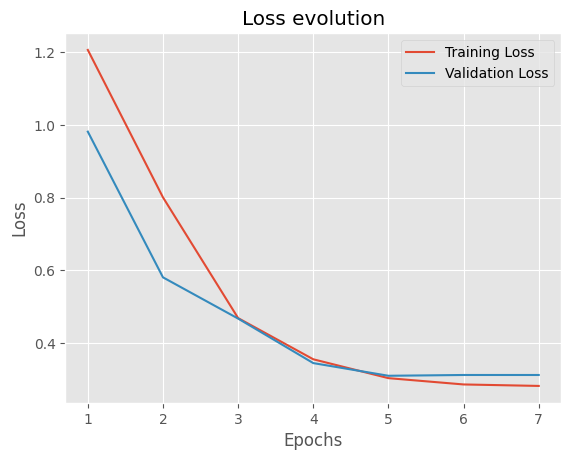

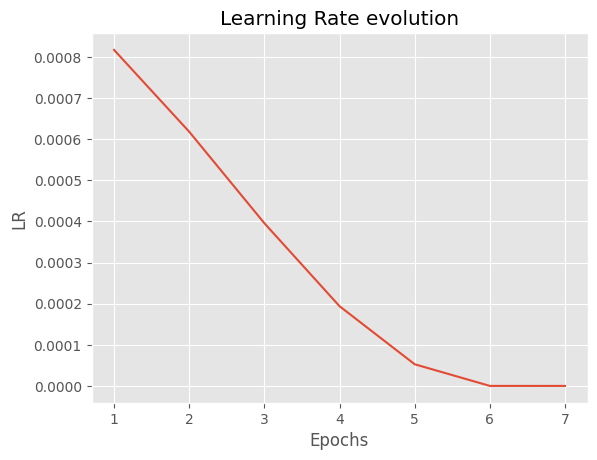

In [9]:
train_loader = DataLoader(
    train_ds,
    batch_size=BS,
    sampler=train_sampler,
    pin_memory=True,
    num_workers=1,
)
valid_loader = DataLoader(
    train_ds,
    batch_size=1,
    sampler=valid_sampler,
    pin_memory=True,
    num_workers=1,
)
for epoch in range(1, EPOCHS + 1):
    train_loss = 0.0
    n_tot_chunks = 0
    pbar = tqdm(
        train_loader, desc="Training", unit="batch"
    )
    model.train()
    for step,(X_batch, y_batch) in enumerate(pbar):
        y_batch = y_batch.to(device, non_blocking=True)
        pred = torch.zeros(y_batch.shape).to(device, non_blocking=True)
        optimizer.zero_grad()
        scheduler.step(step+train_size*epoch)
        h = None

        seq_len = X_batch.shape[1]
        for i in range(0, seq_len, max_chunk_size):
            X_chunk = X_batch[:, i : i + max_chunk_size].float()

            X_chunk = X_chunk.to(device, non_blocking=True)

            y_pred, h = model(X_chunk, h)
            h = [hi.detach() for hi in h]
            pred[:, i : i + max_chunk_size] = y_pred
            del X_chunk,y_pred

        loss = criterion(
            normalize(pred).float(),
            y_batch.float(),
        )
        loss.backward()
        train_loss += loss.item()
        n_tot_chunks+=1
        pbar.set_description(f'Training: loss = {(train_loss/n_tot_chunks):.2f}')

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1e-1)
        optimizer.step()
        del pred,loss,y_batch,X_batch,h
        gc.collect()
    train_loss /= len(train_loader)
    del pbar
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)

    if epoch % 1 == 0:
        valid_loss = evaluate(
            model, max_chunk_size, valid_loader, device, criterion
        )

        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(
                model.state_dict(),
                os.path.join(model_path, f"model_best.pth"),
            )

        dt = time.time() - dt
        print(
            f"{epoch}/{EPOCHS} -- ",
            f"train_loss = {train_loss:.6f} -- ",
            f"valid_loss = {valid_loss:.6f} -- ",
            f"time = {dt:.6f}s",
        )
        dt = time.time()

plot_history(history, model_path=model_path)

In [10]:
history_path = os.path.join(model_path, "history.json")
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=4)